In [128]:
import pandas as pd
import numpy as np 
import random 
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math 
from collections import defaultdict
import json, math, gdown
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt
import re

def make_aesthetic(hex_color_list=None, with_gridlines=False, bold_title=False, save_transparent=True, font_scale=2):
    """Make Seaborn look clean and add space between title and plot"""
    
    # Note: To make some parts of title bold and others not:
    # plt.title(r$'\bf{bolded title}$\nAnd a non-bold subtitle')
    
    sns.set(style='white', context='paper', font_scale=font_scale)
    if not hex_color_list:
        hex_color_list = [
        "#826AED", # Medium slate blue
        "#D41876", # Telemagenta
        "#00A896", # Persian green,
        "#89DAFF", # Pale azure
        "#F7B2AD", # Melon
        "#342E37", # Dark grayish-purple
        "#7DCD85", # Emerald
        "#E87461", # Medium-bright orange
        "#E3B505", # Saffron
        "#2C3531", # Dark charcoal gray with a green undertone
        "#D4B2D8", # Pink lavender
        "#7E6551", # Coyote
        "#F45B69", # Vibrant pinkish-red
        "#020887", # Phthalo Blue
        "#F18805"  # Tangerine
        ]
    sns.set_palette(sns.color_palette(hex_color_list))
    try:
        plt.rcParams['font.family'] = 'Arial'
    except:
        pass
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.titlelocation'] = 'left'
    if bold_title:
        plt.rcParams['axes.titleweight'] = 'bold'
    else:
        plt.rcParams['axes.titleweight'] = 'regular'
    plt.rcParams['axes.grid'] = with_gridlines
    plt.rcParams['grid.alpha'] = 0.5
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['legend.framealpha'] = 0.8
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['savefig.transparent'] = save_transparent
    plt.rcParams['savefig.bbox'] = 'tight'
    plt.rcParams['savefig.pad_inches'] = 0.1
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['axes.titlepad'] = 20*(font_scale/1)

def clean_vars(s, how='title'):
    """
    Simple function to clean titles

    Params
    - s: The string to clean
    - how (default='title'): How to return string. Can be either ['title', 'lowercase', 'uppercase']

    Returns
    - cleaned string
    """
    assert how in ['title', 'lowercase', 'uppercase'], "Bad option!! see docs"
    s = re.sub('([a-z0-9])([A-Z])', r'\1 \2', s)
    s = s.replace('_', ' ')
    if how == 'title':
        return s.title()
    elif how=='lower':
        return s.lower()
    elif how=='upper':
    	return s.upper()
    
make_aesthetic()


# Data Merging

Add open or closed

In [110]:
df = pd.read_json("clean_battle_20240313.json", dtype={'tstamp':'object'})
meta_df = pd.read_csv("model_names_annot.csv")


# We need to merge meta_df on model_a and model_b
for col in meta_df.columns:
    meta_df[f"a_{col}"] = meta_df[col].str.strip()
    meta_df[f"b_{col}"] = meta_df[col].str.strip()

df = pd.merge(df, meta_df[['a_short_name', 'a_open_or_closed', "a_long_name"]], left_on=['model_a'], right_on=['a_long_name'])
df = pd.merge(df, meta_df[['b_short_name', 'b_open_or_closed', "b_long_name"]], left_on=['model_b'], right_on=['b_long_name'])
df.to_csv("all_annot.csv")
df.sample(30).to_csv("all_annot_sample.csv")

# Data Wrangling

In [116]:
def print_dates(df):
    print("MIN AND MAX DATES")
    print(df['tstamp_fix'].min())
    print(df['tstamp_fix'].max())

def label_battle(x):
    a_type = x['a_open_or_closed']
    b_type = x['b_open_or_closed']
    model_types = [a_type, b_type]
    model_set = set(model_types)
    
    if len(model_set) == 2:
        return "open_closed"
    elif model_set == {"open"}:
        return "open_open"
    elif model_set == {"closed"}:
        return "closed_closed"

####################
# Exclusion criteria 
####################
df = df[df['anony']==True]
df = df[df['b_open_or_closed'] != '-1']
df = df[df['a_open_or_closed'] != '-1']
df = df[df['winner'] != "tie"]

####################
# Adding fields for 
# date and battle type
####################
df['tstamp_fix'] = pd.to_datetime(df['tstamp'].astype(float), unit='s')
df['segment'] = df['tstamp_fix'].dt.floor('30D')
df['segment_int'] = pd.factorize(df['segment'])[0]+1
df['battle_type'] = df.apply(lambda x: label_battle(x), axis=1)


# Descriptives

TOTAL COUNT 369564
battle_type
closed_closed    0.407264
open_closed      0.356707
open_open        0.236029
Name: proportion, dtype: float64


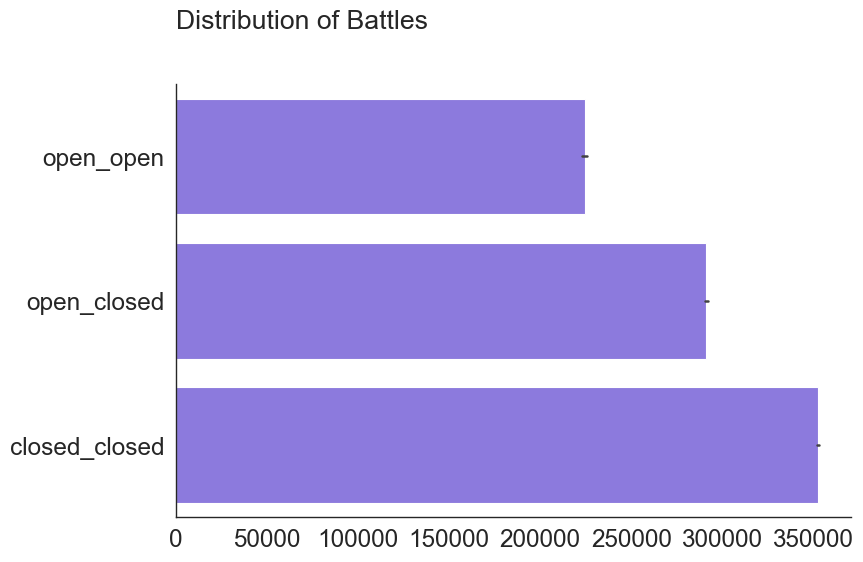

a_open_or_closed
closed    0.585915
open      0.414085
Name: proportion, dtype: float64


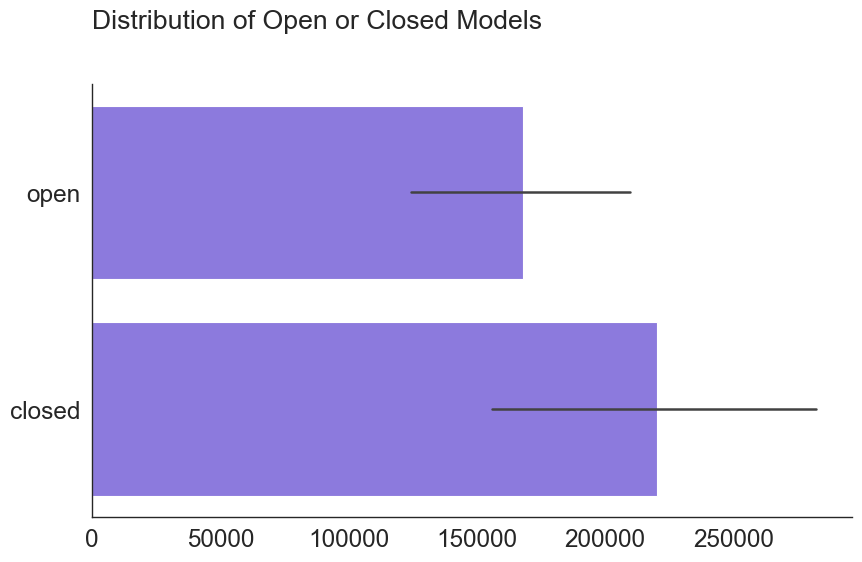

Mean 5435, Median 3409, SD 4979, Min 239, Max 23786


Text(0.0, 1.0, 'Count of Models')

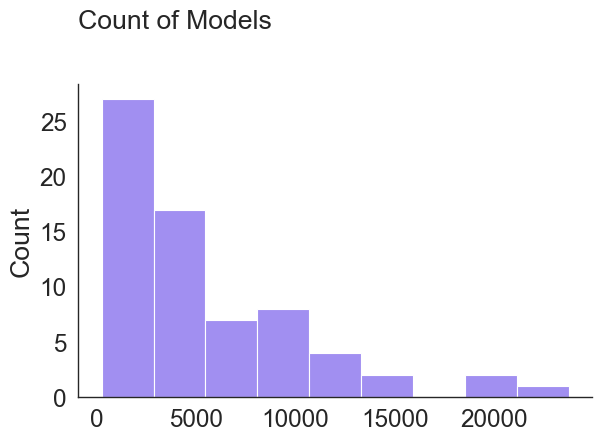

In [113]:
def count_plot(data, dv, clean_title, fig_size=(9,6)):
    plt.figure(figsize=fig_size)
    sns.barplot(data[dv])
    plt.title(clean_title)
    plt.ylabel("")
    plt.show()


print("TOTAL COUNT", len(df))
    
# Count of battles
print(df['battle_type'].value_counts(normalize=True))
count_plot(df, dv="battle_type", clean_title="Distribution of Battles")

# Count of open or closed models
print(df['a_open_or_closed'].value_counts(normalize=True))
count_plot(df.drop_duplicates(subset=['model_a']), dv="a_open_or_closed", clean_title="Distribution of Open or Closed Models")

# Count of models 
model_counts = sorted(df['model_a'].value_counts().to_list())
print(f"Mean {np.mean(model_counts):.0f}, Median {np.median(model_counts):.0f}, SD {np.std(model_counts):.0f}, Min {np.min(model_counts):.0f}, Max {np.max(model_counts):.0f}")
sns.histplot(model_counts)
plt.title("Count of Models")



# Elo Scores

These functions are improted from the original notebook. 

## Functions

In [125]:
def compute_mle_elo(df, SCALE=400, BASE=10, INIT_RATING=1000):
    df = df.sort_values(ascending=True, by=['tstamp'])
    models = pd.concat([df["model_a"], df["model_b"]]).unique()
    models = pd.Series(np.arange(len(models)), index=models)

    # duplicate battles
    df = pd.concat([df, df], ignore_index=True)
    p = len(models.index)
    n = df.shape[0]

    X = np.zeros([n, p])
    X[np.arange(n), models[df["model_a"]]] = +math.log(BASE)
    X[np.arange(n), models[df["model_b"]]] = -math.log(BASE)

    # one A win => two A win
    Y = np.zeros(n)
    Y[df["winner"] == "model_a"] = 1.0

    # one tie => one A win + one B win
    # find tie + tie (both bad) index
    tie_idx = (df["winner"] == "tie") | (df["winner"] == "tie (bothbad)")
    tie_idx[len(tie_idx)//2:] = False
    Y[tie_idx] = 1.0

    lr = LogisticRegression(fit_intercept=False)
    lr.fit(X,Y)

    elo_scores = SCALE * lr.coef_[0] + INIT_RATING

    # set anchor as llama-2-70b-chat = 1082
    if "llama-2-70b-chat" in models.index:
        elo_scores += 1082 - elo_scores[models["llama-2-70b-chat"]]
    return pd.Series(elo_scores, index = models.index).sort_values(ascending=False)

def get_bootstrap_result(battles, func_compute_elo, num_round):
    rows = []
    for i in tqdm(range(num_round), desc="bootstrap"):
        rows.append(func_compute_elo(battles.sample(frac=1.0, replace=True)))
    df = pd.DataFrame(rows)
    return df[df.median().sort_values(ascending=False).index]


## Compute for slices

In [171]:
dfs = []
for slice in df['segment'].unique():
    tdf = df[df['segment'] == slice]
    elo_mle_ratings = compute_mle_elo(tdf)
    elo_df = pd.DataFrame(elo_mle_ratings).reset_index()
    elo_df.columns = ['model', 'elo']
    elo_df['segment'] = slice
    dfs.append(elo_df)

elo_df_m = pd.concat(dfs)
elo_df_m2 = pd.merge(elo_df_m, meta_df[['short_name', 'open_or_closed', "long_name"]], left_on=['model'], right_on=['long_name'])
elo_df_m2['segment_int'] = pd.factorize(elo_df_m2['segment'])[0]


## Graph overall

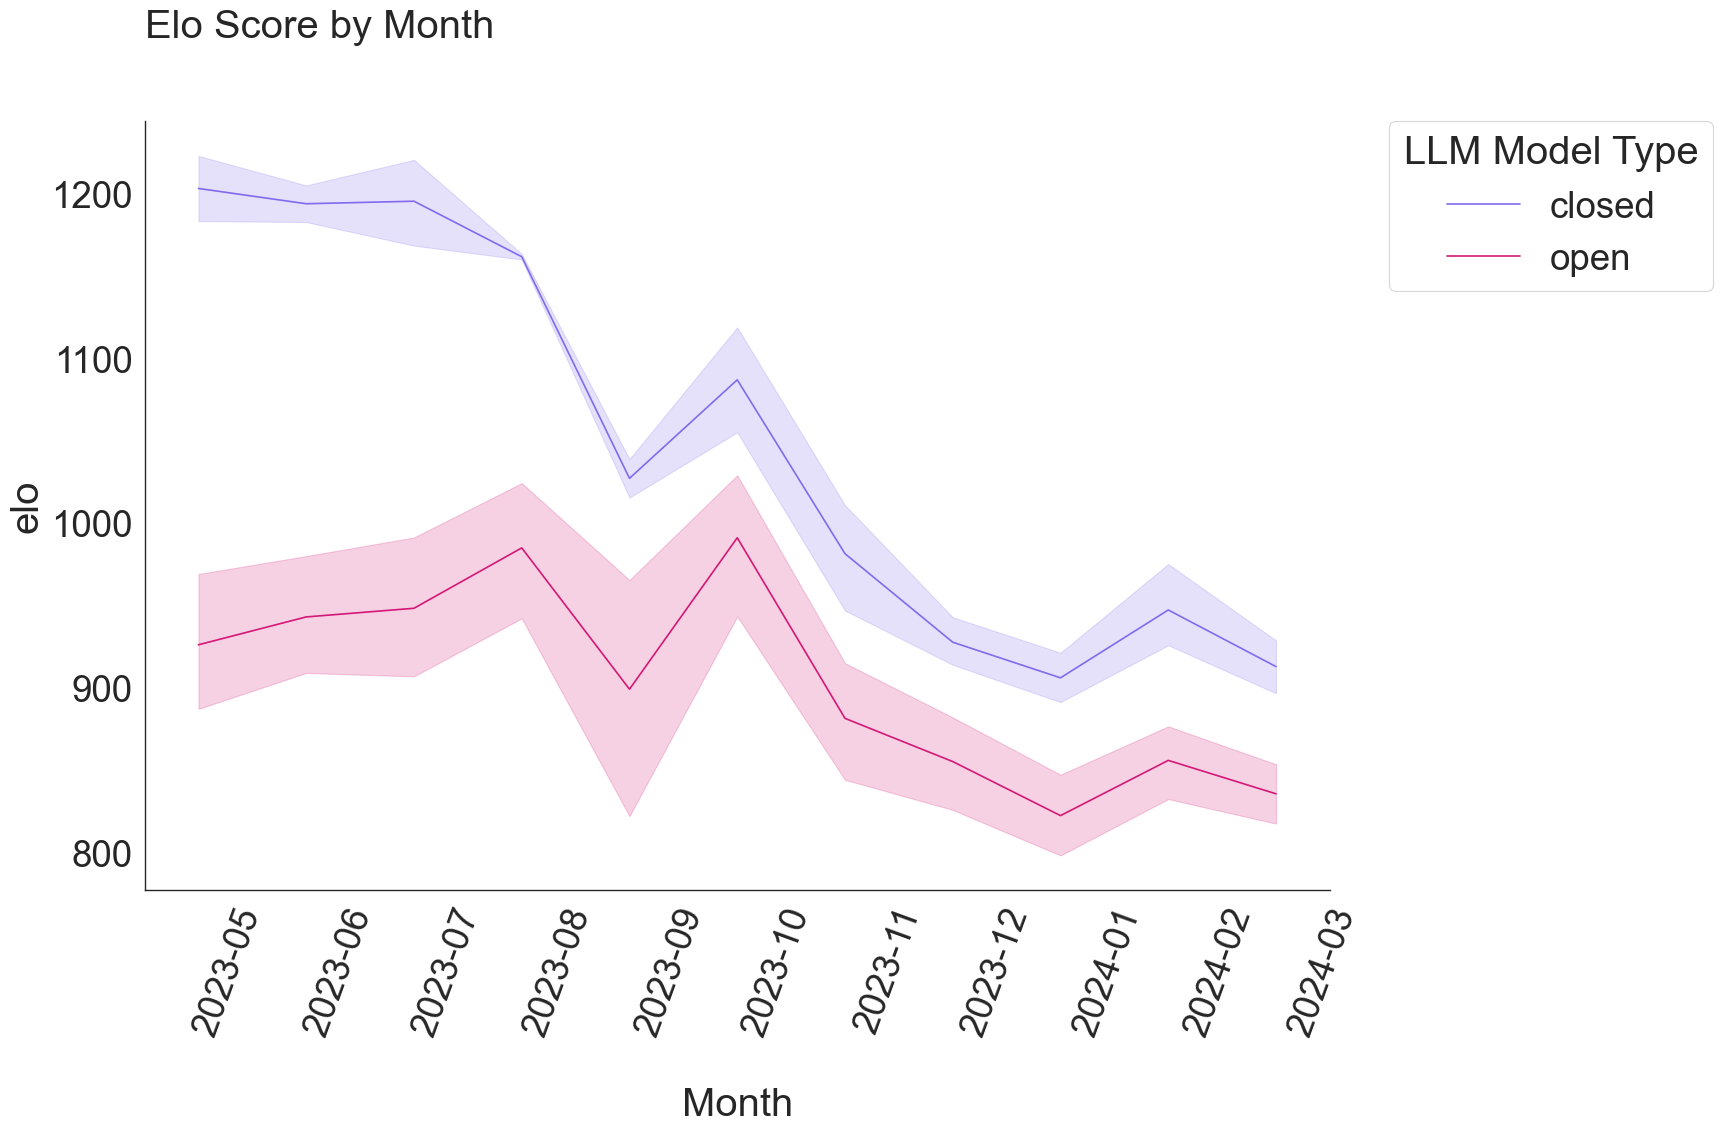

In [173]:
plt.figure(figsize=(18,12))
make_aesthetic(font_scale=3)
sns.lineplot(data=elo_df_m2, x='segment', y='elo', hue='open_or_closed')
plt.title("Elo Score by Month")
plt.xlabel("\nMonth")
plt.xticks(rotation=70)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title="LLM Model Type")
plt.tight_layout()  
plt.show()

In [167]:
elo_df_m2.to_csv("elo_df.csv")

In [175]:
import numpy as np

# Filter the dataset into open and closed subsets
closed_df = elo_df_m2[elo_df_m2['open_or_closed'] == 'closed']
open_df = elo_df_m2[elo_df_m2['open_or_closed'] == 'open']

##################################
# bootstrap results
##################################
def bootstrap_ratios(closed_group, open_group, n=1000):
    mean_ratios = []
    median_ratios = []

    for _ in range(n):
        closed_sample = closed_group['elo'].sample(len(closed_group), replace=True)
        open_sample = open_group['elo'].sample(len(open_group), replace=True)

        closed_mean = closed_sample.mean()
        open_mean = open_sample.mean()

        closed_median = closed_sample.median()
        open_median = open_sample.median()

        mean_ratios.append(closed_mean / open_mean)
        median_ratios.append(closed_median / open_median)

    mean_rat = np.mean(mean_ratios)
    median_rat = np.mean(median_ratios)

    lower_mean_rat, upper_mean_rat = np.percentile(mean_ratios, [2.5, 97.5])
    lower_median_rat, upper_median_rat = np.percentile(median_ratios, [2.5, 97.5])

    return mean_rat, lower_mean_rat, upper_mean_rat, median_rat, lower_median_rat, upper_median_rat


##################################
# run for each segment
##################################
bootstrap_results = []
for segment in elo_df_m2['segment'].unique():
    closed_group = closed_df[closed_df['segment'] == segment]
    open_group = open_df[open_df['segment'] == segment]

    mean_rat, lower_mean_rat, upper_mean_rat, median_rat, lower_median_rat, upper_median_rat = bootstrap_ratios(closed_group, open_group)

    bootstrap_results.append({
        'segment': segment,
        'closed_mean': closed_group['elo'].mean(),
        'open_mean': open_group['elo'].mean(),
        'closed_median': closed_group['elo'].median(),
        'open_median': open_group['elo'].median(),
        'mean_rat': mean_rat,
        'lower_mean_rat': lower_mean_rat,
        'upper_mean_rat': upper_mean_rat,
        'median_rat': median_rat,
        'lower_median_rat': lower_median_rat,
        'upper_median_rat': upper_median_rat
    })

bootstrap_df = pd.DataFrame(bootstrap_results)

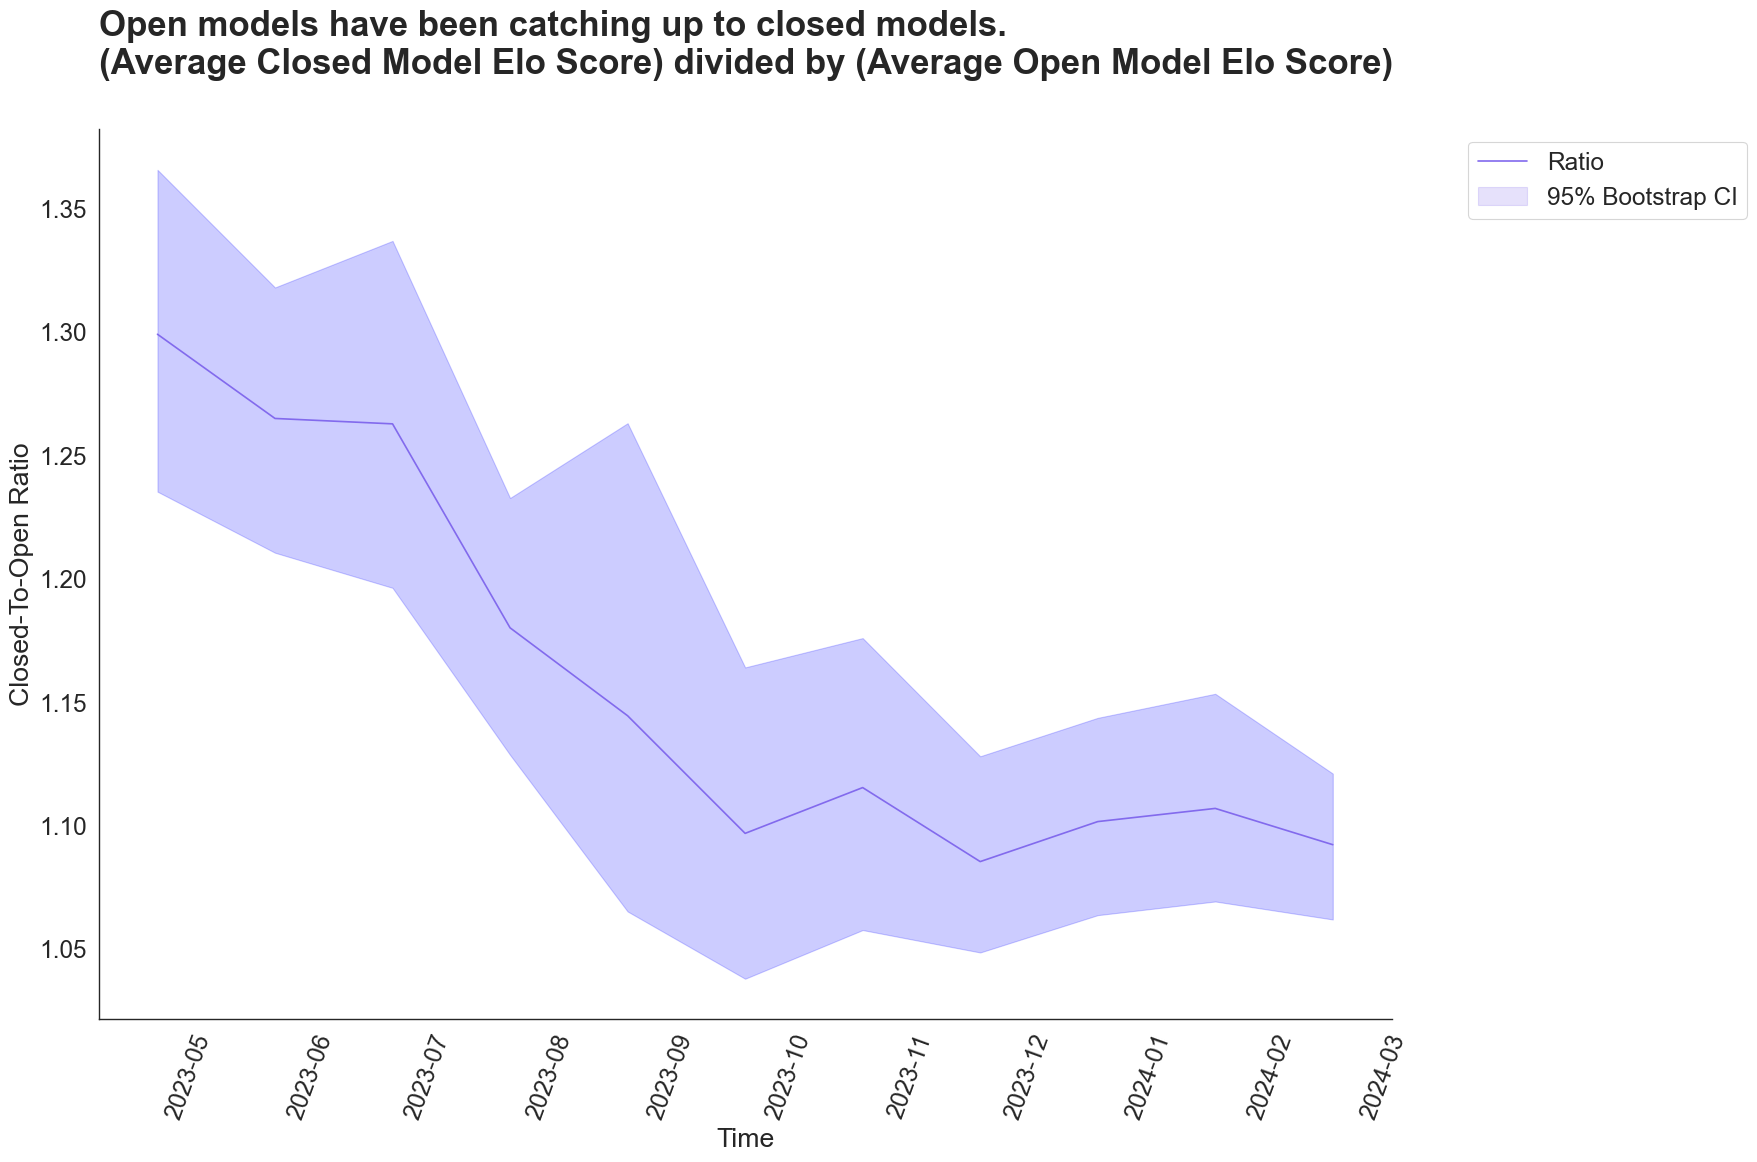

In [225]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the line plot
plt.figure(figsize=(18,12))
sns.lineplot(data=bootstrap_df, x='segment', y='mean_rat')

# Add the 95% confidence interval
plt.fill_between(
    bootstrap_df['segment'], 
    bootstrap_df['lower_mean_rat'], 
    bootstrap_df['upper_mean_rat'], 
    color='blue', 
    alpha=0.2, 
    label='Bootstrap 95% Confidence Interval'
)

# Call make_aesthetic() function here if it's defined to set aesthetic parameters
make_aesthetic(font_scale=2)

plt.title("Open models have been catching up to closed models.\n(Average Closed Model Elo Score) divided by (Average Open Model Elo Score)", size=25, fontweight='bold')
plt.xlabel("Segment")
plt.ylabel("Closed-To-Open Ratio")
plt.legend(["Ratio", "95% Bootstrap CI"], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Time")
plt.xticks(rotation=70)

plt.show()
